Data from Kaggle: https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset/data

In [124]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import string
from collections import Counter, defaultdict
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
import nltk
nltk.download('punkt')
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import nlpaug.augmenter.word as naw

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

sns.set()
custom_palette = {'positive': 'mediumseagreen', 'negative': 'indianred'}

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wojwo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wojwo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Goals

1. Find key aspects that make a restaurant good or bad
2. Predict review rating
3. Expand knowledge about NLP techniques, neural networks and model metrics

## Data Overview

In [2]:
data_raw = pd.read_csv('restaurant_reviews.csv')

In [3]:
data_raw.head()

Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   
1  Ambience is too good for a pleasant evening. S...      5   
2  A must try.. great food great ambience. Thnx f...      5   
3  Soumen das and Arun was a great guy. Only beca...      5   
4  Food is good.we ordered Kodi drumsticks and ba...      5   

                  Metadata             Time  Pictures    7514  
0   1 Review , 2 Followers  5/25/2019 15:54         0  2447.0  
1  3 Reviews , 2 Followers  5/25/2019 14:20         0     NaN  
2  2 Reviews , 3 Followers  5/24/2019 22:54         0     NaN  
3    1 Review , 1 Follower  5/24/2019 22:11         0     NaN  
4  3 Reviews , 2 Followers  5/24/2019 21:37         0     NaN

In [4]:
data_raw.isnull().sum()

Restaurant       0
Reviewer        38
Review          45
Rating          38
Metadata        38
Time            38
Pictures         0
7514          9999
dtype: int64

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  10000 non-null  object 
 1   Reviewer    9962 non-null   object 
 2   Review      9955 non-null   object 
 3   Rating      9962 non-null   object 
 4   Metadata    9962 non-null   object 
 5   Time        9962 non-null   object 
 6   Pictures    10000 non-null  int64  
 7   7514        1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


In [6]:
mask = data_raw['7514'].notnull()
data_raw[mask]

Restaurant           Reviewer  \
0  Beyond Flavours  Rusha Chakraborty   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   

                 Metadata             Time  Pictures    7514  
0  1 Review , 2 Followers  5/25/2019 15:54         0  2447.0

## Clean Data

In [7]:
data = data_raw.copy()

In [8]:
to_drop = data[data['Rating'] == 'Like'].index
data.drop(to_drop, inplace=True)
data['Rating'] = data['Rating'].astype(float)

In [9]:
data['Time'] = pd.to_datetime(data['Time'], format='%m/%d/%Y %H:%M')

In [10]:
data.drop(['7514'], axis=1, inplace=True)

In [11]:
data.dropna(subset=['Rating', 'Review'], inplace=True)

In [12]:
data.columns = data.columns.str.lower()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   restaurant  9954 non-null   object        
 1   reviewer    9954 non-null   object        
 2   review      9954 non-null   object        
 3   rating      9954 non-null   float64       
 4   metadata    9954 non-null   object        
 5   time        9954 non-null   datetime64[ns]
 6   pictures    9954 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 622.1+ KB


## EDA

In [281]:
def show_category_countplot(data_ref, x, hue = None):
    if x == hue:
        return
    
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))  
    
    if hue:
        sns.countplot(data=data_ref, x=x, hue=hue, ax=ax1, palette=custom_palette)
        ax1.set_title(f'Countplot of {x} and {hue}')
    else:
        sns.countplot(data=data_ref, x=x, ax=ax1, color='lightseagreen')
        ax1.set_title(f'Countplot of {x}')
    
    for p in ax1.patches:
        height = p.get_height()
        if height > 0:
            xy = (p.get_x() + p.get_width() / 2., height)
            ax1.annotate(f'{height}', xy, ha='center', va='bottom', color='gray')
    
    plt.tight_layout()
    plt.show()

In [15]:
def print_category_percentages(data_ref, x):
    category_counts = data_ref[x].value_counts(normalize=True) * 100
    formatted_category_counts = category_counts.map('{:.2f}%'.format)
    print(formatted_category_counts)

### Rating

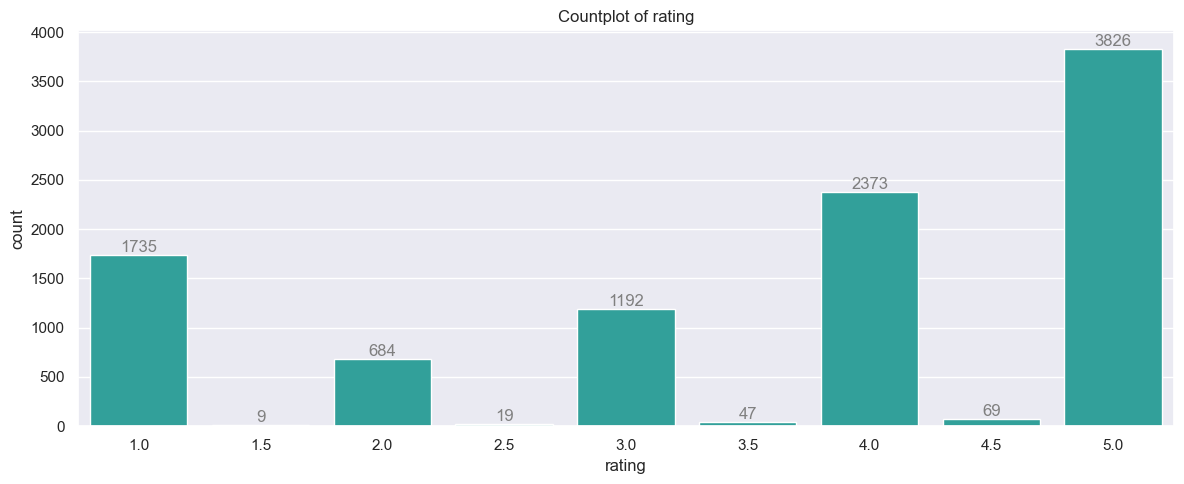

In [282]:
show_category_countplot(data, 'rating')

In [17]:
print_category_percentages(data, 'rating')

5.0    38.44%
4.0    23.84%
1.0    17.43%
3.0    11.98%
2.0     6.87%
4.5     0.69%
3.5     0.47%
2.5     0.19%
1.5     0.09%
Name: rating, dtype: object


### Label

In [18]:
def create_label(rating):
    if rating >= 3.0:
        return 'positive'
    if rating <= 2.5:
        return 'negative'
    return 'neutral'

In [19]:
data['label'] = data['rating'].apply(create_label)

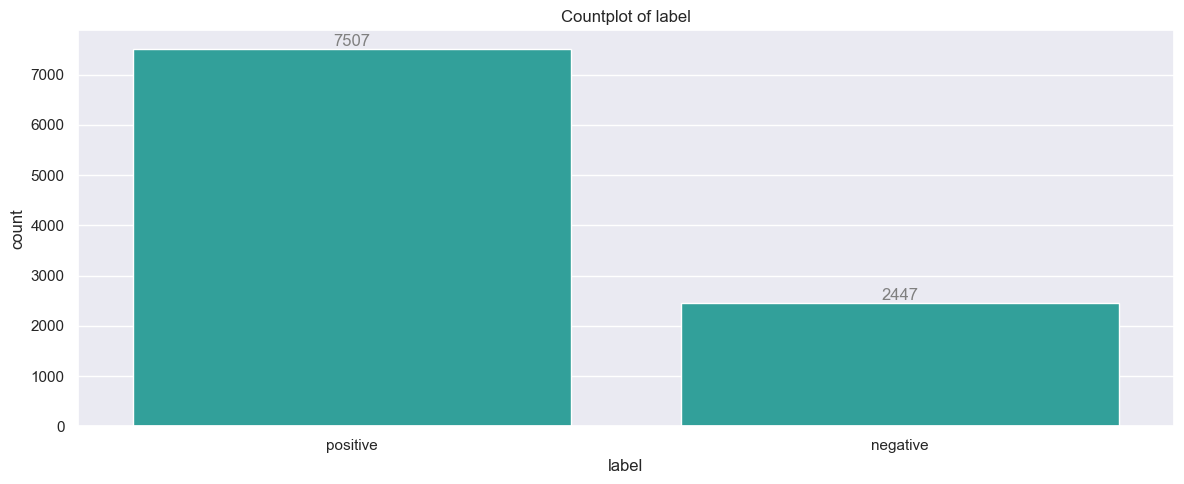

In [283]:
show_category_countplot(data, 'label')

In [21]:
print_category_percentages(data, 'label')

positive    75.42%
negative    24.58%
Name: label, dtype: object


### Review Preprocessing

In [22]:
data_raw['Review'].unique()

array(['The ambience was good, food was quite good . had Saturday lunch , which was cost effective .\nGood place for a sate brunch. One can also chill with friends and or parents.\nWaiter Soumen Das was really courteous and helpful.',
       'Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service',
       'A must try.. great food great ambience. Thnx for the service by Pradeep and Subroto. My personal recommendation is Penne Alfredo Pasta:) ....... Also the music in the background is amazing.',
       ...,
       'Bad rating is mainly because of "Chicken Bone found in Veg food" and is not acceptable for a Vegetarian.\n\nTo satiate Cravings for chinese food we headed to Chinese Pavilion and there was also a voucher available in Little app for Luncheon tray for Rs 310 (Veg) [well do not bother for the voucher as the price for Veg Luncheon tray is Rs 275/- + taxes in the restaurant itself).\n\nThe am

In [23]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text) # remove adressses
    text = re.sub(r'www\.\S+', '', text) # remove adresses
    text = text.replace('.', ' ')
    text = text.replace('...', ' ')
    text = text.replace(',', ' ')
    text = re.sub(r'[^\w\s]', '', text) # remove punctuations and symbols
    text = re.sub('\w*\d\w*', '', text) # remove words with digits
    text = text.replace('  ', ' ')
    text = text.replace('   ', ' ')
    text = text.replace('\n', '')
    
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    tokens = word_tokenize(text)
    cleaned_tokens = []
    
    for tok in tokens:
        if tok not in stop_words:
            cleaned_tokens.append(stemmer.stem(tok))
    
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [24]:
data['review_cleaned'] = data['review'].apply(clean_text)

In [25]:
data.sample(5)

restaurant            reviewer  \
3730  Kritunga Restaurant        Alladi Nihar   
2370                 Amul          Ajay Bende   
844           Hyper Local  Mahesh Kumar Unnam   
1110      Barbeque Nation  M.shravan Chowdary   
959           Cream Stone       Shalini Pilli   

                                                 review  rating  \
3730  Irrespective of their high reputation of being...     2.0   
2370                                            awesome     5.0   
844   Pizza is good...nice staff...ambiance good but...     4.0   
1110  Had to wait a bit to get a table that's a good...     5.0   
959   One busy place especially in the evenings.\nCr...     4.0   

                        metadata                time  pictures     label  \
3730   27 Reviews , 12 Followers 2018-10-01 20:34:00         0  negative   
2370      0 Reviews , 1 Follower 2018-07-28 00:31:00         0  positive   
844     10 Reviews , 5 Followers 2019-04-21 07:01:00         3  positive   
1110   2 Reviews , 104 Followers 2019-04-07 16:30:00         0  positive   
959   75 Reviews , 260 Followers 2018-12-20 07:20:00         0  positive   

                                         review_cleaned  
3730  irrespect high reput authent andhra food resta...  
2370                                             awesom  
844   pizza good nice staff ambianc good better visi...  
1110  wait bit get tabl that good thing great food b...  
959   one busi place especi even cream stone creat s...

In [26]:
data_raw['Review'].unique()[17]

"The best thing about this place is the food. My favorite go to dish here is definitely Alfredo Pasta although other items are good as well. And the service and behavior of the staff is top-notch. We we're attended by Mr. Soumen Das and he was extremely polite. Will definitely visit soon."

In [27]:
data['review_cleaned'].unique()[17]

'best thing place food favorit go dish definit alfredo pasta although item good well servic behavior staff topnotch attend mr soumen da extrem polit definit visit soon'

Review was cleaned of punctuation, emojis, numbers, etc. Then it was stemmed and tokenized. 

### Time
Date when review was publicated. 

In [297]:
data['date'] = data['time'].dt.date

In [311]:
date_count = data['date'].value_counts().sort_index()
date_count_df = pd.DataFrame(date_count).reset_index()
date_count_df.columns = ['date', 'count']

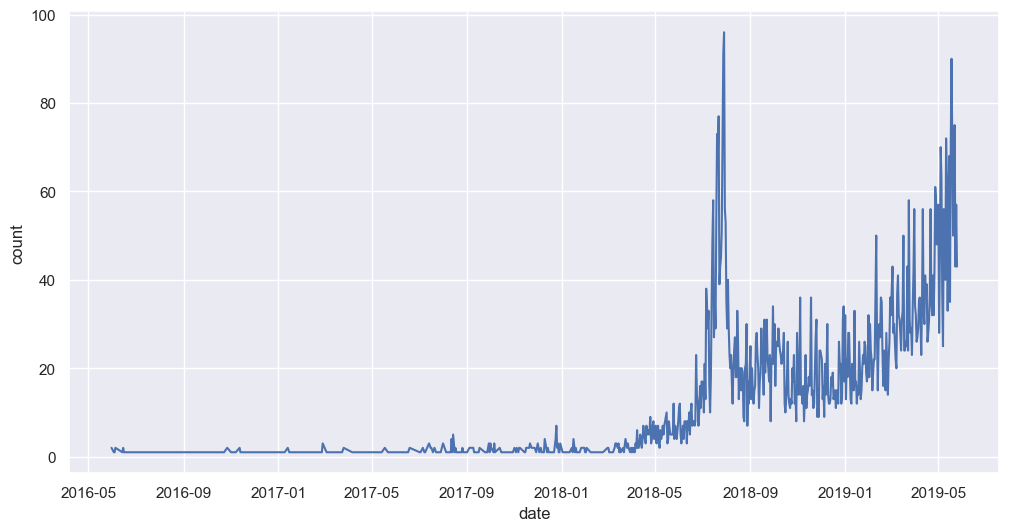

In [313]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='count', data=date_count_df)
plt.show()

There are peaks in the summer season. 

### Letter Count

A number of letter for each review.

In [28]:
def count_letters(text):
    return len(text.replace(" ", ""))

In [29]:
data['review_letter_count'] = data['review'].apply(count_letters)

In [30]:
def show_numerical_box_plot(data_ref, x, y):       
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))    
    sns.boxplot(data=data_ref, x=x, y=y, width=0.5, palette=custom_palette)
    ax1.set_title(f'Boxplot of {x} and {y}')
    
    plt.tight_layout()
    plt.show()

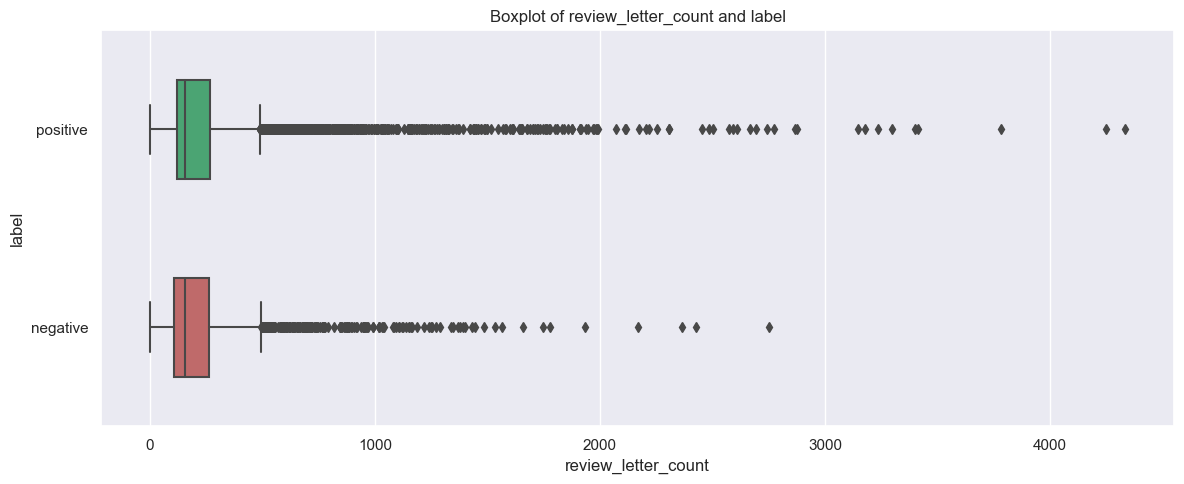

In [31]:
show_numerical_box_plot(data, 'review_letter_count', 'label')

In [32]:
def show_histplot(data, x, hue, xmin=None, xmax=None):
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))    
    sns.histplot(data=data, x=x, hue=hue, bins=1000, multiple='stack', palette=custom_palette)
    ax1.set_title(f'Histplot of {x} and {hue}')
    
    if xmin is not None and xmax is not None:
        ax1.set_xlim(xmin, xmax)   
    
    plt.tight_layout()
    plt.show()

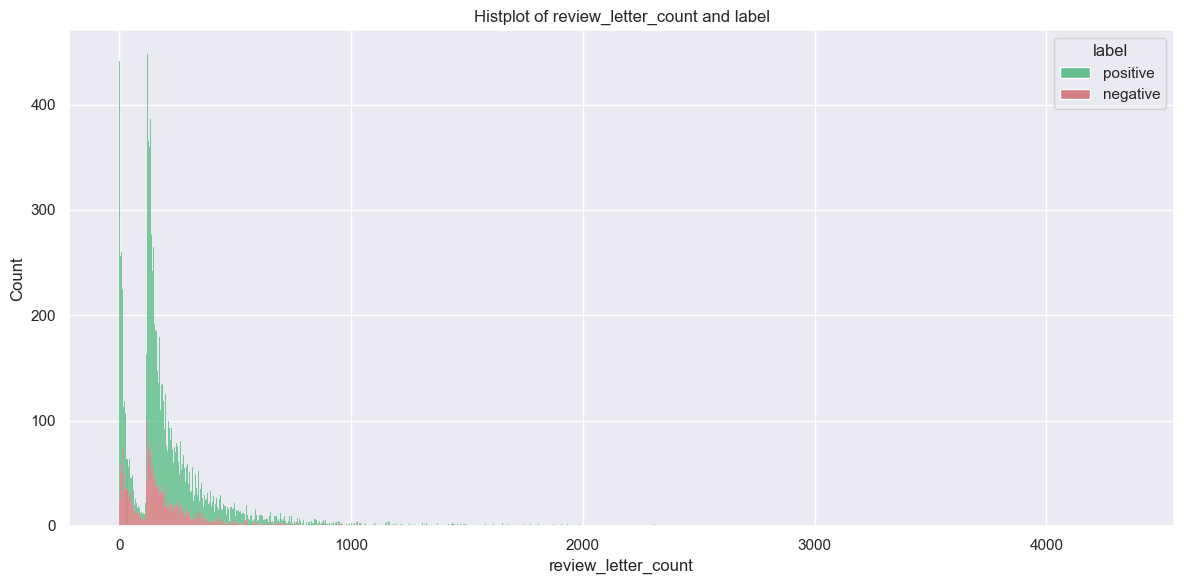

In [33]:
show_histplot(data, 'review_letter_count', 'label')

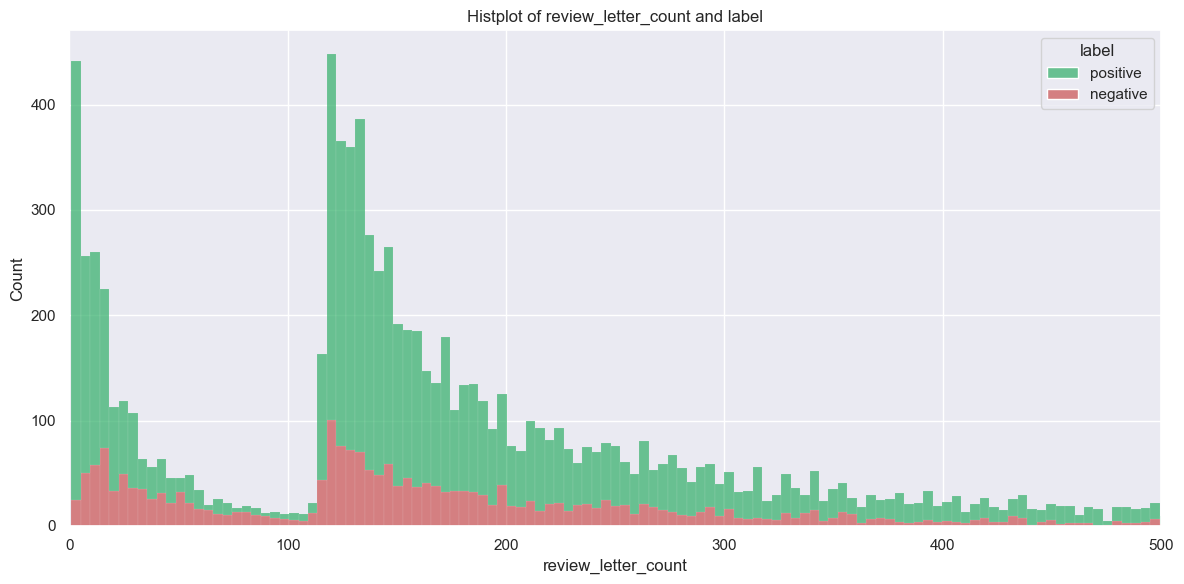

In [34]:
show_histplot(data, 'review_letter_count', 'label', 0, 500)

- There is an interesting sudden rise after number of 100.  
- A lot of outliers. 

### Word Count

A number of words for each review.

In [35]:
def count_words(text):
    return len(text.split(" "))

In [36]:
data['review_words_count'] = data['review'].apply(count_words)

In [315]:
data['review_words_count'].describe()

count    9954.000000
mean       49.050532
std        59.103939
min         1.000000
25%        24.000000
50%        34.000000
75%        57.000000
max       964.000000
Name: review_words_count, dtype: float64

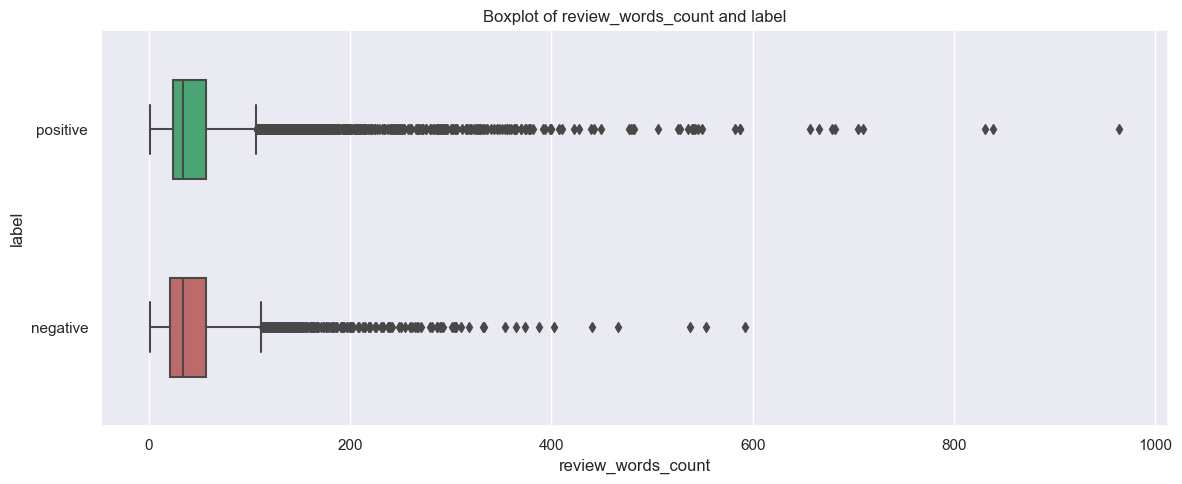

In [37]:
show_numerical_box_plot(data, 'review_words_count', 'label')

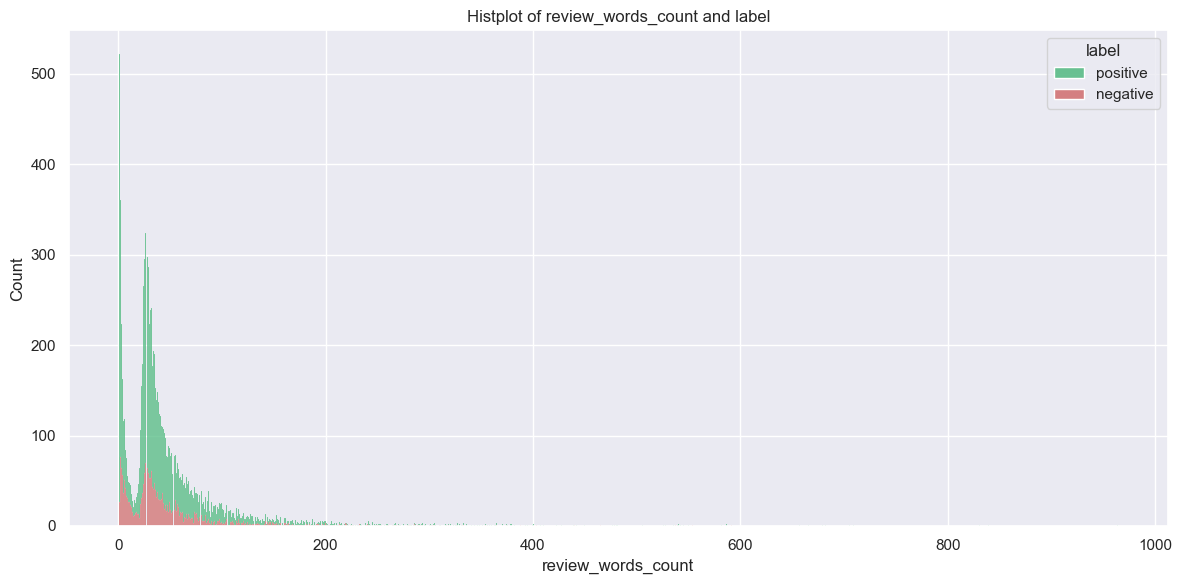

In [38]:
show_histplot(data, 'review_words_count', 'label')

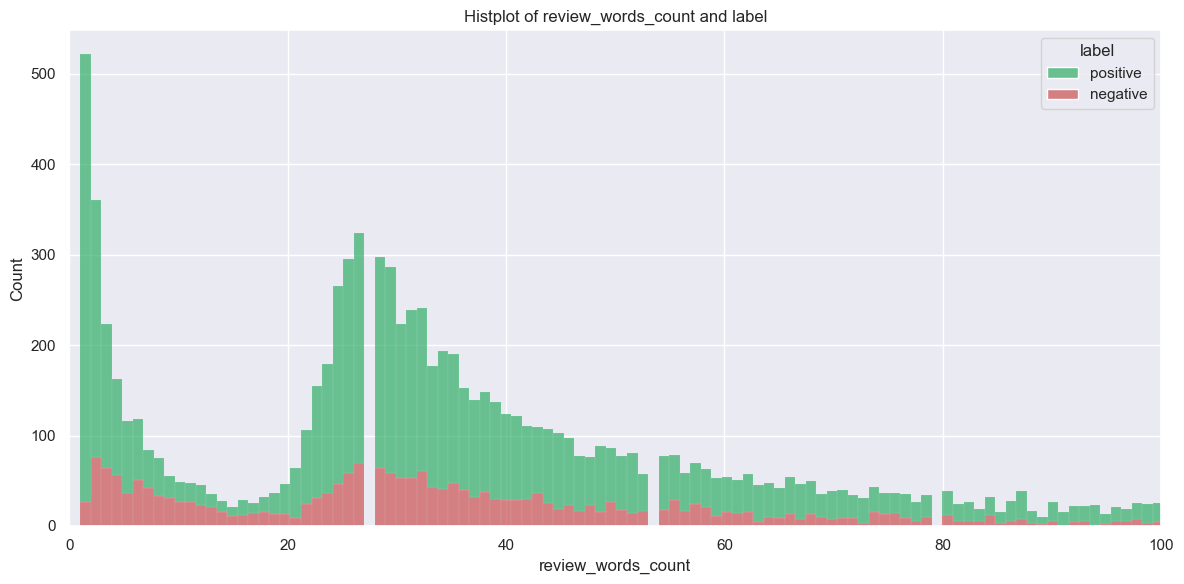

In [39]:
show_histplot(data, 'review_words_count', 'label', 0, 100)

In [40]:
most_popular_len = data['review_words_count'].value_counts().nlargest(10)
most_popular_len

1     522
2     361
27    324
28    298
26    295
29    286
25    265
32    241
31    239
3     223
Name: review_words_count, dtype: int64

Conclusions like above in letter section. 

### Longest and shortest reviews

In [41]:
display(data.sort_values(by='review_letter_count')['review'].head(10))

8281    d
5280    .
8830    .
3743    o
9528    1
6274    .
1583    üòÑ
4281    a
3736    4
8379    y
Name: review, dtype: object

In [42]:
data.sort_values(by='review_letter_count')['review_cleaned'].head(10)

8281    
5280    
8830    
3743    
9528    
6274    
1583    
4281    
3736    
8379    
Name: review_cleaned, dtype: object

In [43]:
data.loc[data['review_cleaned'].str.len() < 3]['review'].head(10)

1564    Hhsjoibohoogogigivigigu8gihohohohphpjpjpjjohoh...
1577                                                   ok
1583                                                    üòÑ
1994                                               OK not
2090                                                    D
2362                                                   su
3576                                                   gd
3583                                                    5
3585                                                   ok
3594                                                   cc
Name: review, dtype: object

In [44]:
data.sort_values(by='review_words_count', ascending=False)['review_cleaned'].head(10).unique()

array(['hyderabadi daawat name suggest authent hyderabadi food get eat function hyderabad ever hyderabadi daawat hotel talk function well youv one definit know much hyderabadi love food much spend menu hyderabadi daawat restaur get splendid varieti dish enjoy hotel easi locat main road come orr gachibowli side come right side your come miyapur side left restaur simpl yet beauti interior calm cozi place also banquet hall confer hall also undertak cater order parti function dastar set sat food first brought yakhni shorba shorba noth soup yakhni shorba dish kashmir peopl north tend good sourc protein usual mild spice level hyderabadi daawat owe spice crave hyderabadi made littl spici tast fantast best way start meal next came starter serv wok toss chicken phuket fish sikandari raan murgh sholay kebab let start love sikandari raan one whole leg goat sheep know fact mutton beef arent usual tender chicken chef hyderabadi daawat chang notion entir mutton raan soo soft tender juici teeth work 

In [317]:
data.sort_values(by='review_words_count', ascending=False)['review'].head(1)

9622    Hyderabadi Daawat as the name suggests has som...
Name: review, dtype: object

### Review Preprocessing

In [22]:
data_raw['Review'].unique()

array(['The ambience was good, food was quite good . had Saturday lunch , which was cost effective .\nGood place for a sate brunch. One can also chill with friends and or parents.\nWaiter Soumen Das was really courteous and helpful.',
       'Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service',
       'A must try.. great food great ambience. Thnx for the service by Pradeep and Subroto. My personal recommendation is Penne Alfredo Pasta:) ....... Also the music in the background is amazing.',
       ...,
       'Bad rating is mainly because of "Chicken Bone found in Veg food" and is not acceptable for a Vegetarian.\n\nTo satiate Cravings for chinese food we headed to Chinese Pavilion and there was also a voucher available in Little app for Luncheon tray for Rs 310 (Veg) [well do not bother for the voucher as the price for Veg Luncheon tray is Rs 275/- + taxes in the restaurant itself).\n\nThe am

In [23]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text) # remove adressses
    text = re.sub(r'www\.\S+', '', text) # remove adresses
    text = text.replace('.', ' ')
    text = text.replace('...', ' ')
    text = text.replace(',', ' ')
    text = re.sub(r'[^\w\s]', '', text) # remove punctuations and symbols
    text = re.sub('\w*\d\w*', '', text) # remove words with digits
    text = text.replace('  ', ' ')
    text = text.replace('   ', ' ')
    text = text.replace('\n', '')
    
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    tokens = word_tokenize(text)
    cleaned_tokens = []
    
    for tok in tokens:
        if tok not in stop_words:
            cleaned_tokens.append(stemmer.stem(tok))
    
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [24]:
data['review_cleaned'] = data['review'].apply(clean_text)

In [25]:
data.sample(5)

restaurant            reviewer  \
3730  Kritunga Restaurant        Alladi Nihar   
2370                 Amul          Ajay Bende   
844           Hyper Local  Mahesh Kumar Unnam   
1110      Barbeque Nation  M.shravan Chowdary   
959           Cream Stone       Shalini Pilli   

                                                 review  rating  \
3730  Irrespective of their high reputation of being...     2.0   
2370                                            awesome     5.0   
844   Pizza is good...nice staff...ambiance good but...     4.0   
1110  Had to wait a bit to get a table that's a good...     5.0   
959   One busy place especially in the evenings.\nCr...     4.0   

                        metadata                time  pictures     label  \
3730   27 Reviews , 12 Followers 2018-10-01 20:34:00         0  negative   
2370      0 Reviews , 1 Follower 2018-07-28 00:31:00         0  positive   
844     10 Reviews , 5 Followers 2019-04-21 07:01:00         3  positive   
1110   2 Reviews , 104 Followers 2019-04-07 16:30:00         0  positive   
959   75 Reviews , 260 Followers 2018-12-20 07:20:00         0  positive   

                                         review_cleaned  
3730  irrespect high reput authent andhra food resta...  
2370                                             awesom  
844   pizza good nice staff ambianc good better visi...  
1110  wait bit get tabl that good thing great food b...  
959   one busi place especi even cream stone creat s...

In [26]:
data_raw['Review'].unique()[17]

"The best thing about this place is the food. My favorite go to dish here is definitely Alfredo Pasta although other items are good as well. And the service and behavior of the staff is top-notch. We we're attended by Mr. Soumen Das and he was extremely polite. Will definitely visit soon."

In [27]:
data['review_cleaned'].unique()[17]

'best thing place food favorit go dish definit alfredo pasta although item good well servic behavior staff topnotch attend mr soumen da extrem polit definit visit soon'

Review was cleaned of punctuation, emojis, numbers, etc. Then it was stemmed and tokenized. 

### Most common words and phrases

In [45]:
def create_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

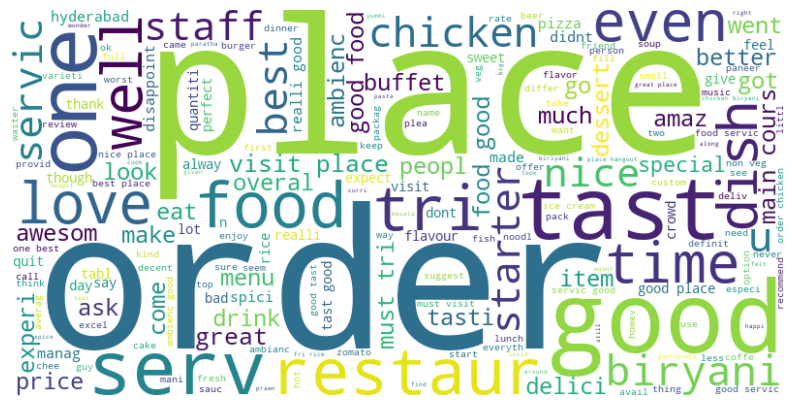

In [46]:
all_words = ' '.join(data['review_cleaned'])
create_word_cloud(all_words)

In [50]:
def create_common_words_df(data_ref, x):
    all_words = ' '.join(data_ref[x])
    
    common_words = {}
    all_words_splitted = all_words.split(' ')
    for w in all_words_splitted:
        if w in common_words.keys():
            common_words[w] += 1
        else:
            common_words[w] = 1
            
    df_common_words = pd.DataFrame.from_dict(common_words, orient='index', columns=['Value'])
    df_common_words.reset_index(inplace=True)
    df_common_words.columns = ['word', 'occurrences']
    
    return df_common_words

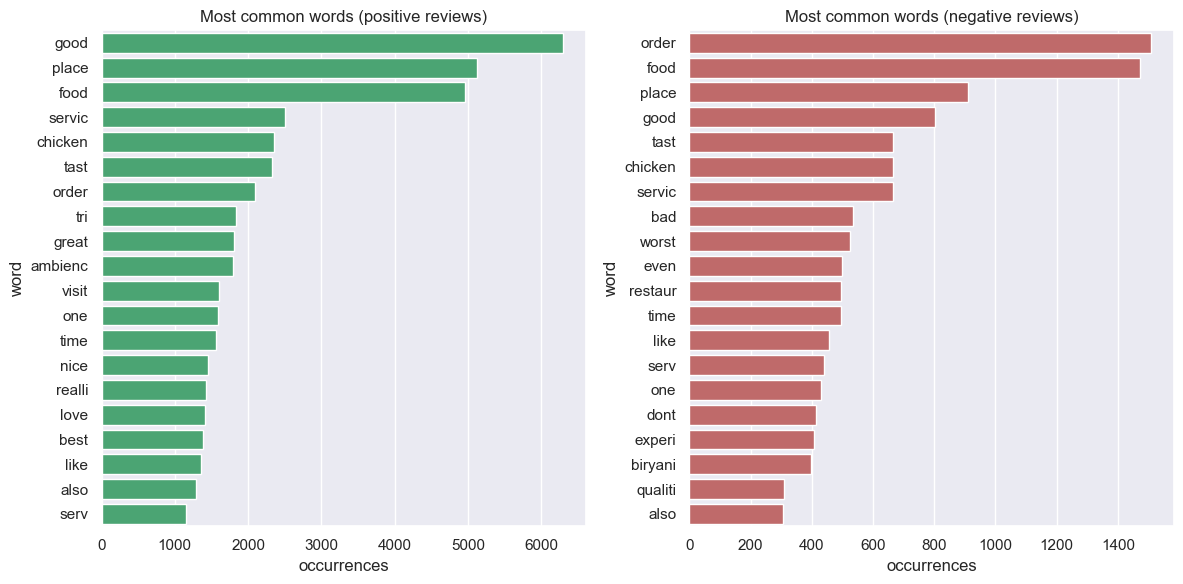

In [243]:
filtered = data.loc[data['label'] == 'positive']
df_most_common_words_positive = create_common_words_df(filtered, 'review_cleaned').sort_values(by='occurrences', ascending=False).head(20)

filtered = data.loc[data['label'] == 'negative']
df_most_common_words_negative = create_common_words_df(filtered, 'review_cleaned').sort_values(by='occurrences', ascending=False).head(20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  

sns.barplot(y=df_most_common_words_positive['word'], x=df_most_common_words_positive['occurrences'], color='mediumseagreen', ax=ax1, orient='h')
ax1.set_title('Most common words (positive reviews)')

sns.barplot(y=df_most_common_words_negative['word'], x=df_most_common_words_negative['occurrences'], color='indianred', ax=ax2, orient='h')
ax2.set_title('Most common words (negative reviews)')

plt.tight_layout()
plt.show()

In [55]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

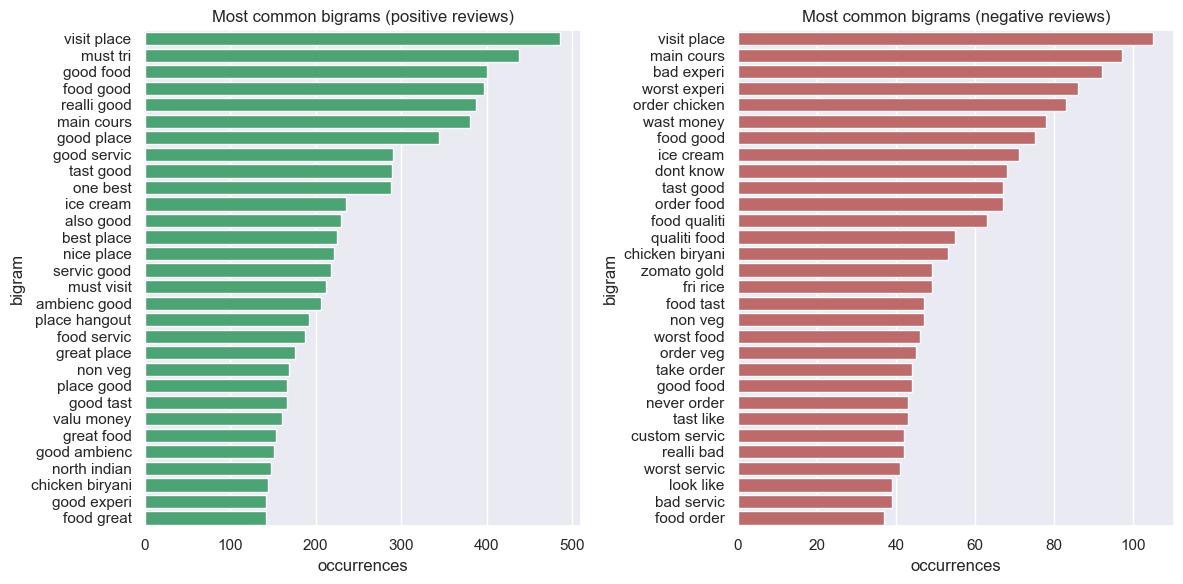

In [263]:
filtered = data.loc[data['label'] == 'positive']
df_bigrams_positive = pd.DataFrame(get_top_n_bigram(filtered['review_cleaned'], 30), columns=['bigram', 'occurrences'])

filtered = data.loc[data['label'] == 'negative']
df_bigrams_negative = pd.DataFrame(get_top_n_bigram(filtered['review_cleaned'], 30), columns=['bigram', 'occurrences'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  

sns.barplot(y=df_bigrams_positive['bigram'], x=df_bigrams_positive['occurrences'], color='mediumseagreen', ax=ax1, orient='h')
ax1.set_title('Most common bigrams (positive reviews)')

sns.barplot(y=df_bigrams_negative['bigram'], x=df_bigrams_negative['occurrences'], color='indianred', ax=ax2, orient='h')
ax2.set_title('Most common bigrams (negative reviews)')

plt.tight_layout()
plt.show()

In [58]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

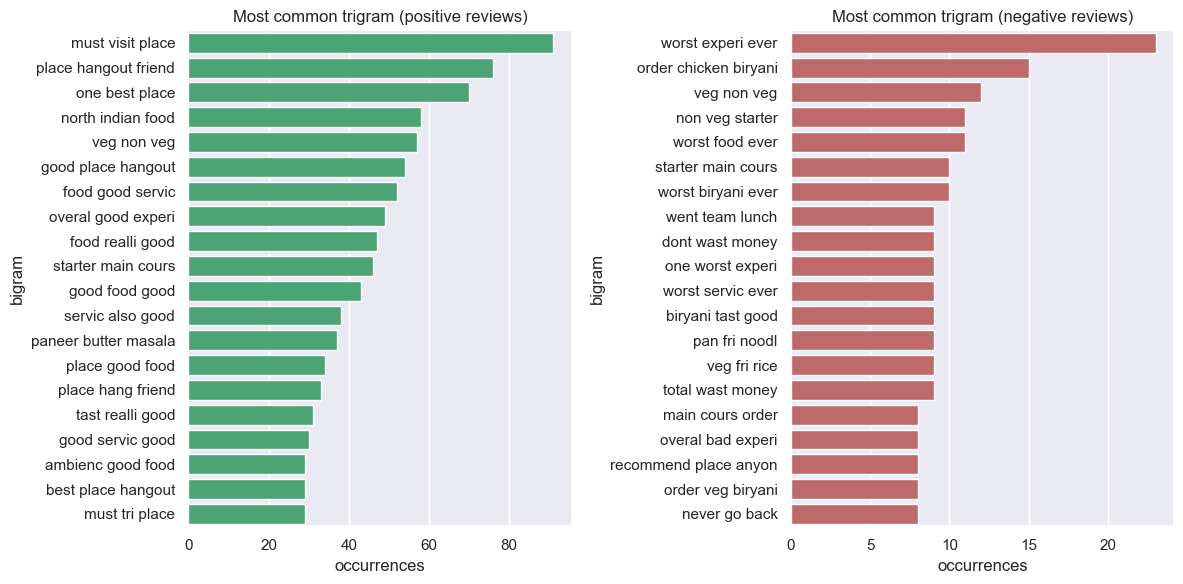

In [248]:
filtered = data.loc[data['label'] == 'positive']
df_bigrams_positive = pd.DataFrame(get_top_n_trigram(filtered['review_cleaned'], 20), columns=['bigram', 'occurrences'])

filtered = data.loc[data['label'] == 'negative']
df_bigrams_negative = pd.DataFrame(get_top_n_trigram(filtered['review_cleaned'], 20), columns=['bigram', 'occurrences'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  

sns.barplot(y=df_bigrams_positive['bigram'], x=df_bigrams_positive['occurrences'], color='mediumseagreen', ax=ax1, orient='h')
ax1.set_title('Most common trigram (positive reviews)')

sns.barplot(y=df_bigrams_negative['bigram'], x=df_bigrams_negative['occurrences'], color='indianred', ax=ax2, orient='h')
ax2.set_title('Most common trigram (negative reviews)')

plt.tight_layout()
plt.show()

In [271]:
def get_percent_of_occurances(word, df_ref):
    df_ref_count = df_ref.shape[0]
    occurances = df_ref[df_ref['word'] == word].iloc[0]['occurrences']
    return round(occurances / df_ref_count, 3) * 100

In [279]:
common_words_df = create_common_words_df(data, 'review_cleaned')

words = [
    'chicken',
    'food',
    'servic',
    'ambienc',
    'friend',
    'masala',
    'veg',
    'ice'
]

for w in words:
    print(f"{w} occurances: {get_percent_of_occurances(w, common_words_df)}%")

chicken occurances: 22.2%
food occurances: 47.3%
servic occurances: 23.3%
ambienc occurances: 14.499999999999998%
friend occurances: 6.4%
masala occurances: 2.3%
veg occurances: 8.200000000000001%
ice occurances: 3.1%


- Clients most often write about food taste.
- But service is also high in the rank. 
- Negative reviews often contain bad opinion about lack of vegan option. 
- Many clients pay attention to biryani chicken and ice cream (but chicken more). Negative reviews often contain bad opinion about these dishes. 
- In positive reviews clients often praise the place as a good place for hangout with friends.
- Paneer butter masala and North Indian Food often in good reviews. 
- Saying 'good place' clients mean visual values of the restaurant, good positioning in the city or overall good experience?

### Word count by Label 

In [61]:
word_count_label_median = data.groupby(by='label', as_index=False).median()
word_count_label_median

label  rating  pictures  review_letter_count  review_words_count
0  negative     1.0       0.0                155.0                34.0
1  positive     5.0       0.0                157.0                34.0

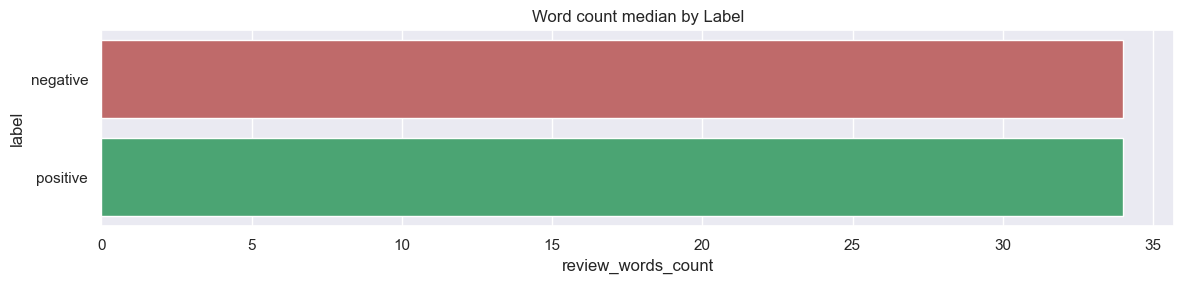

In [319]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 3))  

sns.barplot(y=word_count_label_median['label'], x=word_count_label_median['review_words_count'], palette=custom_palette, ax=ax1, orient='h')
ax1.set_title('Word count median by Label')

plt.tight_layout()
plt.show()

### Restaurant and Reviewer

Name of the reviewed restaurant and name/nickname of the reviewer.

In [63]:
data['restaurant'].value_counts()

Beyond Flavours                          100
KS Bakers                                100
The Indi Grill                           100
The Tilt Bar Republic                    100
Yum Yum Tree - The Arabian Food Court    100
                                        ... 
The Old Madras Baking Company             99
Amul                                      99
Hyderabad Chefs                           98
Arena Eleven                              85
American Wild Wings                       77
Name: restaurant, Length: 100, dtype: int64

In [64]:
data['reviewer'].value_counts().nlargest(20)

Ankita                            13
Parijat Ray                       13
Kiran                             12
Jay Mehta                         11
Vedant Killa                      11
Sravani                           10
Priyanka                          10
Siva Kumar                        10
Age Of Foodies (Suraj Karambe)    10
Manojkumar D Nambisan             10
Vinay                              9
Khushboo Pandey                    9
Prasun Gokhlani                    9
Nillu                              9
Kumar                              9
Prachita Jayaswal                  9
Anusha Sinha                       9
Avin Seth                          8
The Foodie Bookworm                8
Aman Agarwal                       8
Name: reviewer, dtype: int64

The number of reviews is almost the same for each restaurant.

### Pictures

Number of images given with the opinion. 

In [65]:
data.groupby(by='label')['pictures'].describe()

count      mean       std  min  25%  50%  75%   max
label                                                         
negative  2447.0  0.177360  1.020042  0.0  0.0  0.0  0.0  34.0
positive  7507.0  0.939257  2.883757  0.0  0.0  0.0  0.0  64.0

In [66]:
data['pictures'].value_counts().head(10)

0    7971
1     706
2     383
3     246
4     129
5     116
7      86
6      85
8      55
9      47
Name: pictures, dtype: int64

In [67]:
def create_picture_bin(pictures):
    if pictures > 2:
        return '> 2'
    return str(pictures)

In [68]:
data['pictures_bin'] = data['pictures'].apply(create_picture_bin)

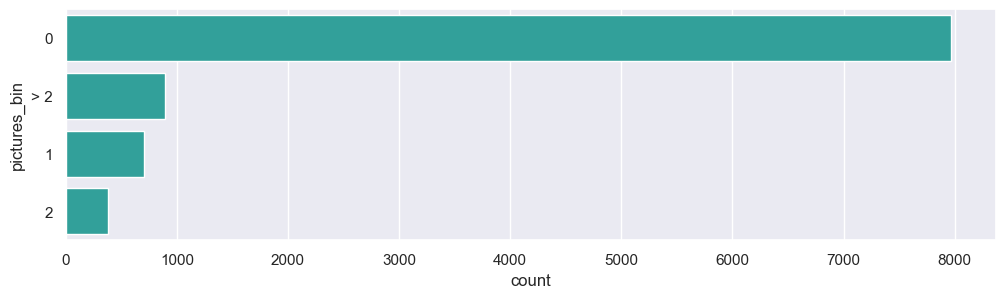

In [280]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.countplot(data=data, y='pictures_bin', orient='h', color='lightseagreen')
plt.show()

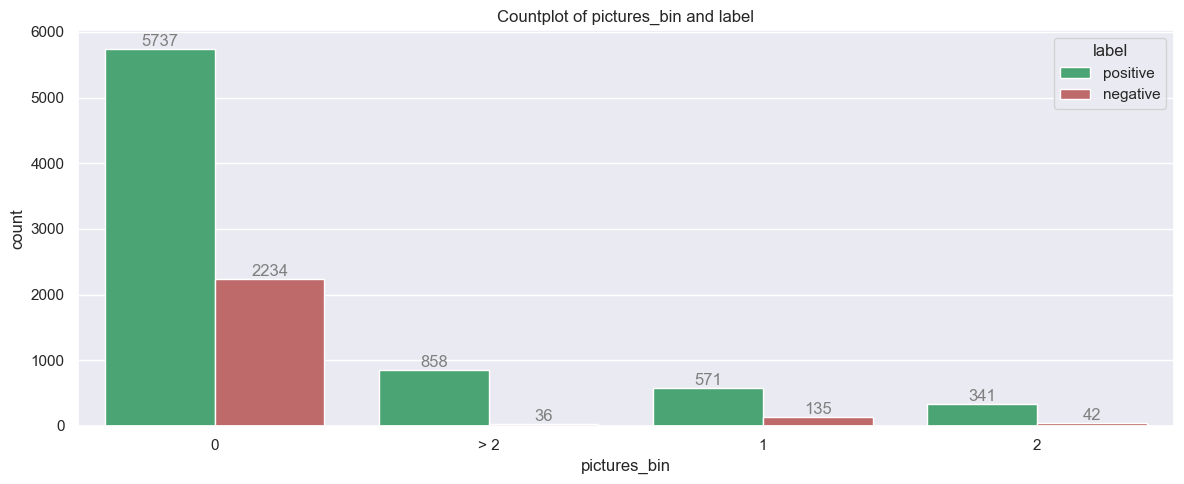

In [284]:
show_category_countplot(data, 'pictures_bin', 'label')

The more pictures, the fewer neutral and negative opinions.

## Training Models

In [152]:
def print_confusion_matrix_heatmap(conf_mat, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', 
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [153]:
def augment_twice(x_train, y_train, labels):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_x = []
    augmented_y = []
    
    for i in range(0, len(y_train)):
        origin_text = x_train.iloc[i]
        origin_label = y_train.iloc[i]
        if origin_label in labels:
            augmented_text = aug.augment(origin_text)
            augmented_x.append(augmented_text)
            augmented_y.append(origin_label)
    
    x_train = x_train.append(pd.Series(augmented_x))
    y_train = y_train.append(pd.Series(augmented_y))
    
    return x_train, y_train

In [154]:
def print_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [155]:
data_copy = data.copy()
data_copy = data_copy.sample(frac=1.0, random_state=42)

# data_copy = data_copy[data_copy['review_letter_count'] < 1500]

x = data_copy['review_cleaned']
y = data_copy['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [156]:
tfid = TfidfVectorizer()
x_train_tfid = tfid.fit_transform(x_train)
x_test_tfid = tfid.transform(x_test)

In [157]:
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

### Speed Training

In [158]:
models = {
    'KNeighborsClassifier' : neighbors.KNeighborsClassifier(),
    'DecisionTreeClassifier' : tree.DecisionTreeClassifier(),
    'RandomForestClassifier' : ensemble.RandomForestClassifier(),
    'SVC' : svm.SVC(),
    'LogisticRegression' : LogisticRegression(max_iter=1000)
}

In [159]:
accuracy = []
m_keys = list(models.keys())
m_values = list(models.values())

for i in range(0, len(models)):
    print(f'Training {m_keys[i]}...')
    cross_val = cross_val_score(m_values[i], x_train_tfid, y_train, scoring='accuracy', cv=StratifiedKFold(3)).mean()
    accuracy.append(cross_val)

Training KNeighborsClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...
Training SVC...
Training LogisticRegression...


In [160]:
score_df = pd.DataFrame({'Model': m_keys, 'Accuracy': accuracy})
score_df

Model  Accuracy
0    KNeighborsClassifier  0.753483
1  DecisionTreeClassifier  0.843651
2  RandomForestClassifier  0.886977
3                     SVC  0.900288
4      LogisticRegression  0.895140

### CNN

In [161]:
# x_train, y_train = augment_twice(x_train, y_train, ['negative'])

In [162]:
y_train_dummies = pd.get_dummies(y_train).values
y_test_dummies = pd.get_dummies(y_test).values

max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

total_word = len(tokenizer.word_index)
print(f'Total distinct words: {total_word}')

max_input_len = 100
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)
x_train_padded = pad_sequences(train_sequences, maxlen=max_input_len, padding='post')
x_test_padded = pad_sequences(test_sequences, maxlen=max_input_len, padding='post')

Total distinct words: 11967


In [163]:
embedding_dim = 100  # Dimension of word embeddings
num_filters = 128  # Number of filters in convolutional layer
kernel_size = 3  # Size of convolutional filters
labels_num = 2 # Number of labels

batch_size = 64
epochs = 5

In [164]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_input_len))
cnn_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(32, activation='linear'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(labels_num, activation='softmax'))

cnn_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [165]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = cnn_model.fit(x_train_padded, y_train_dummies, batch_size=batch_size, epochs=epochs, validation_data=(x_test_padded, y_test_dummies))

Epoch 1/5
125/125 [==============================] - 3s 17ms/step - loss: 0.4049 - accuracy: 0.8153 - val_loss: 0.2433 - val_accuracy: 0.9021
Epoch 2/5
125/125 [==============================] - 2s 15ms/step - loss: 0.2091 - accuracy: 0.9196 - val_loss: 0.2326 - val_accuracy: 0.9041
Epoch 3/5
125/125 [==============================] - 2s 15ms/step - loss: 0.1356 - accuracy: 0.9527 - val_loss: 0.2607 - val_accuracy: 0.8995
Epoch 4/5
125/125 [==============================] - 2s 15ms/step - loss: 0.0823 - accuracy: 0.9725 - val_loss: 0.2824 - val_accuracy: 0.8980
Epoch 5/5
125/125 [==============================] - 2s 15ms/step - loss: 0.0505 - accuracy: 0.9857 - val_loss: 0.3015 - val_accuracy: 0.9076


63/63 [==============================] - 0s 3ms/step - loss: 0.3015 - accuracy: 0.9076
Test Loss: 0.30146723985671997, Test Accuracy: 0.9075841307640076
63/63 [==============================] - 0s 3ms/step


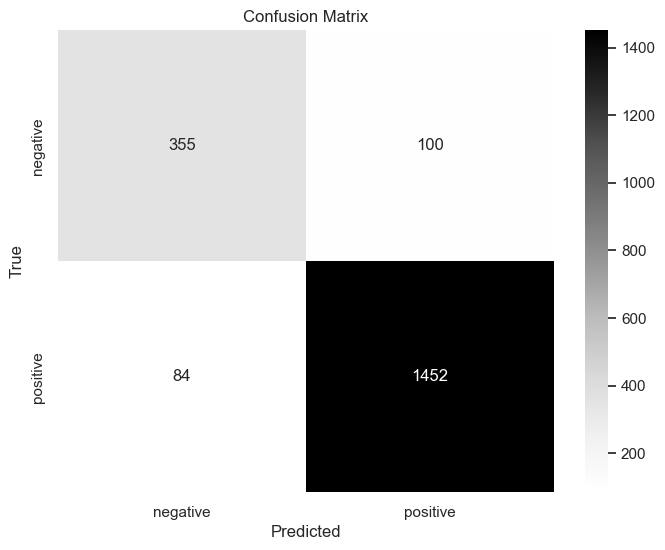

In [169]:
loss, accuracy = cnn_model.evaluate(x_test_padded, y_test_dummies)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

y_pred = np.argmax(cnn_model.predict(x_test_padded), axis=1)
conf_mat = confusion_matrix(np.argmax(y_test_dummies, axis=1), y_pred)
print_confusion_matrix_heatmap(conf_mat, ['negative', 'positive'])

<AxesSubplot:>

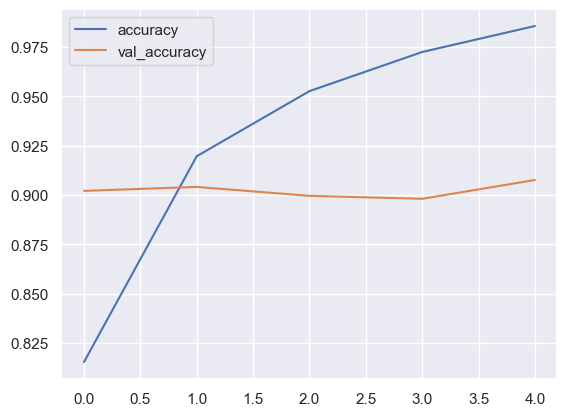

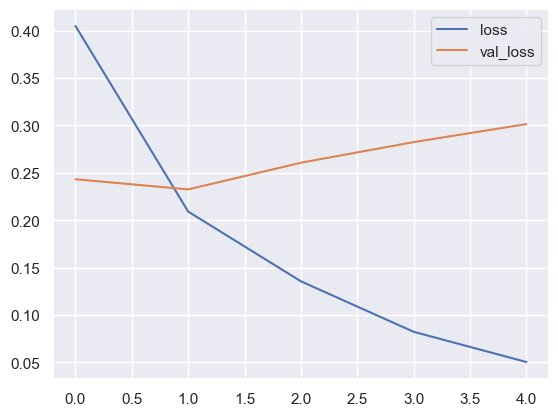

In [170]:
metrics = pd.DataFrame(history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

### LSTM

In [171]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_input_len))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(32, activation='linear'),)
# model.add(Dropout(0.5))
model.add(Dense(labels_num, activation='softmax'))

model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [172]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x_train_padded, y_train_dummies, batch_size=batch_size, epochs=epochs, validation_data=(x_test_padded, y_test_dummies))

Epoch 1/5
125/125 [==============================] - 15s 85ms/step - loss: 0.3734 - accuracy: 0.8371 - val_loss: 0.2581 - val_accuracy: 0.8970
Epoch 2/5
125/125 [==============================] - 10s 82ms/step - loss: 0.1983 - accuracy: 0.9209 - val_loss: 0.2652 - val_accuracy: 0.8915
Epoch 3/5
125/125 [==============================] - 12s 93ms/step - loss: 0.1482 - accuracy: 0.9421 - val_loss: 0.2799 - val_accuracy: 0.8980
Epoch 4/5
125/125 [==============================] - 11s 88ms/step - loss: 0.1162 - accuracy: 0.9560 - val_loss: 0.3055 - val_accuracy: 0.8905
Epoch 5/5
125/125 [==============================] - 12s 95ms/step - loss: 0.0956 - accuracy: 0.9646 - val_loss: 0.3728 - val_accuracy: 0.8865


63/63 [==============================] - 1s 22ms/step - loss: 0.3728 - accuracy: 0.8865
Test Loss: 0.37281614542007446, Test Accuracy: 0.88648921251297
63/63 [==============================] - 2s 15ms/step


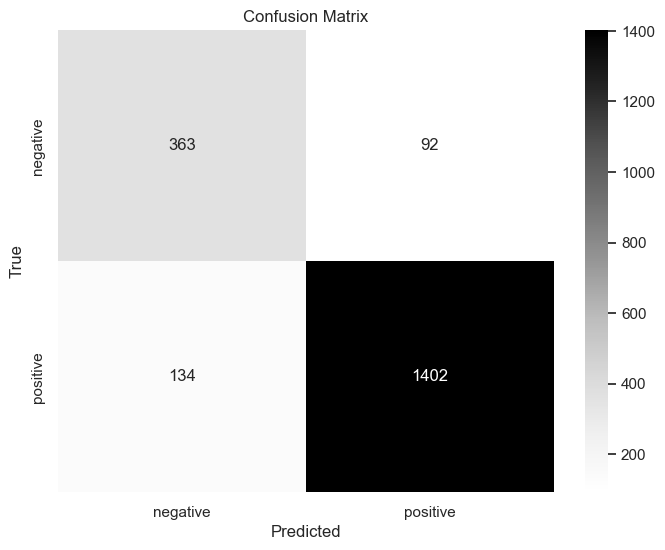

In [173]:
loss, accuracy = model.evaluate(x_test_padded, y_test_dummies)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

y_pred = np.argmax(model.predict(x_test_padded), axis=1)
conf_mat = confusion_matrix(np.argmax(y_test_dummies, axis=1), y_pred)
print_confusion_matrix_heatmap(conf_mat, ['negative', 'positive'])

<AxesSubplot:>

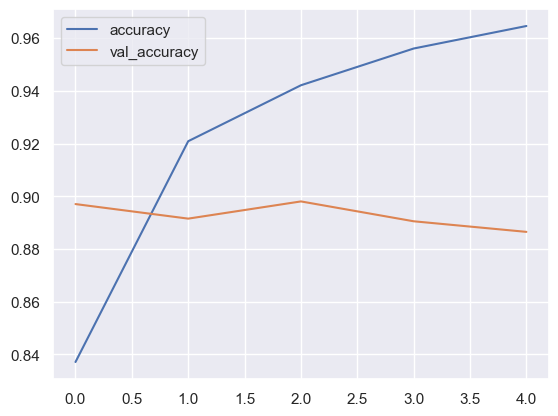

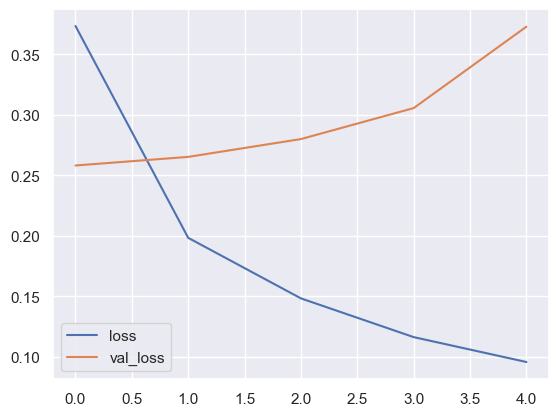

In [174]:
metrics = pd.DataFrame(history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

### Boosting SVC

In [175]:
# param_grid = {
#     'C': [1, 5, 10, 15, 20, 50],
#     'kernel': ['rbf'],
#     'gamma': ['scale'],
#     'class_weight' : [{'positive' : 1, 'negative': 1}, 
#                       {'positive' : 1, 'negative': 2},
#                       {'positive' : 1, 'negative': 3},]
# }

# svc = svm.SVC()
# grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
# grid_search.fit(train_tfid_matrix, y_train)

# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

In [176]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

Accuracy: 0.9005524861878453
Precision: 0.954483695652174
Recall: 0.9147135416666666
F1: 0.9341755319148936


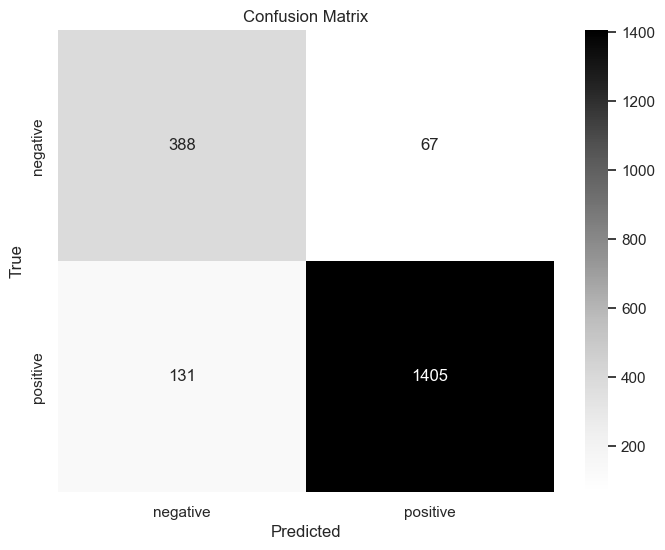

In [177]:
model = svm.SVC(gamma='scale', kernel='rbf', C=1)
model.fit(x_train_tfid, y_train_encoded)

y_pred_origin = model.predict(x_test_tfid)

y_scores = model.decision_function(x_test_tfid)
threshold = 0.3
y_pred = (y_scores > threshold).astype(int)

print_metrics(y_test_encoded, y_pred)
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print_confusion_matrix_heatmap(conf_matrix, le.classes_)

In [178]:
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_scores)

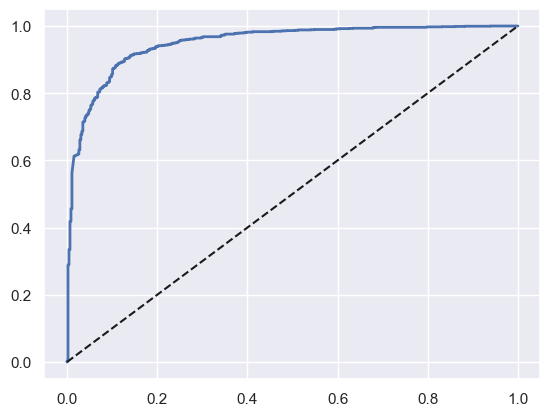

In [179]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
plot_roc_curve(fpr, tpr)
plt.show()

In [180]:
print(f'Before adding threshold: {roc_auc_score(y_test_encoded, y_pred_origin)}')
print(f'After adding threshold: {roc_auc_score(y_test_encoded, y_pred)}') 

Before adding threshold: 0.8449783940018316
After adding threshold: 0.8837303972069596


In [232]:
for i, (index, real_value) in enumerate(y_test.iteritems()):
    prediction = y_pred[i]
    print(f"Review: {data.loc[index]['review']}\nReview cleaned: {data.loc[index]['review_cleaned']}\nRating: {data.loc[index]['rating']}\nPrediction: {le.classes_[y_pred[i]]}, Real Value: {value}\n")

Review: Well you know what they are famous for - Karachi Biscuits. But there is a whole range of stuff to eat at their outlet. There is mini pizzas, fries, Puffs (4/5), Paninis (4/5) and sandwiches. Ofcourse there is a whole range of biscuits, dry fruits and cakes to chose from as well. You wont come out without buying anything. Trust me on this. Have fun at Karachi Bakery. Cheers!
Review cleaned: well know famou karachi biscuit whole rang stuff eat outlet mini pizza fri puff panini sandwich ofcours whole rang biscuit dri fruit cake chose well wont come without buy anyth trust fun karachi bakeri cheer
Rating: 5.0
Prediction: positive, Real Value: positive

Review: The Egg wrap here is made by unprofessionals. The egg wrap's omlette was burnt as hell and I guess they were too lazy to replace it knowing it was burnt and sent me those wraps
. order (id: 1178102975) on Zomato Order.
Review cleaned: egg wrap made unprofession egg wrap omlett burnt hell guess lazi replac know burnt sent wrap

Review: Great place to unwind, hot and sour soup is not recommended and Biryani is must try.. may be menu can have bit more options specially on Indian Cuisine....

Vikrant was very helpful in giving feedback to chef and getting less spicy food for kids...

Ambience .. Best in City!!
Review cleaned: great place unwind hot sour soup recommend biryani must tri may menu bit option special indian cuisin vikrant help give feedback chef get less spici food kid ambienc best citi
Rating: 5.0
Prediction: positive, Real Value: positive

Review: Food - 4/5
Ambience - 3.5/5
Service - 1/5

I visited the place last week. The food was tasty and so was ambience but I have serious concern with the services.

We asked for regular water , and they brought dirty, stinky water just to sell the bottled water. The waiter made facial remarks as in this is what you get for free.

It was highly irresponsible.
Also we had to literally beg them to bring the cheque.

Please train your staff if you want to .
Review

Review: The place has either bought paid reviews or the management has changed or something similar, because we went looking at all the reviews here and it was horrible.
Food is cold tastless, serving is slow and tardy. Most of the items in buffet were not available for the entire two hours we were there.
And to top it,there werent many items served in the buffet
Review cleaned: place either bought paid review manag chang someth similar went look review horribl food cold tastless serv slow tardi item buffet avail entir two hour top werent mani item serv buffet
Rating: 1.0
Prediction: negative, Real Value: positive

Review: Waste of money , tried there Vegetable noodle and chilli chicken gravy combo . Noodle was tasteless , chilly chicken was hard and gravy was just average .
Review cleaned: wast money tri veget noodl chilli chicken gravi combo noodl tasteless chilli chicken hard gravi averag
Rating: 1.0
Prediction: negative, Real Value: positive

Review: The best North Indian food avai

Review: super fast delivary
Review cleaned: super fast delivari
Rating: 5.0
Prediction: positive, Real Value: positive

Review: very spicy and vada is uncooked.. disappointing
Review cleaned: spici vada uncook disappoint
Rating: 2.0
Prediction: negative, Real Value: positive

Review: on time delivery
Review cleaned: time deliveri
Rating: 5.0
Prediction: positive, Real Value: positive

Review: Arena Eleven - A Sports bar which is located at Kondapur at Level 3 in SLN terminus has got varieites of Kebabs and buffet system. Coming to the amibence - They have got 2 big screen's for live sports screening, They have got good music which is not loud (pretty impressive). Staff is very friendly. The waitress who attended us has been very kind to us and made sure that everything was perfect for us. They have got indoor and outdoor seating as well. And i must say outdoor seating will give you a very beautiful view on sunset time. This is a pocket friendly restaurant with a friendly staff

Now com

In [287]:
pickle.dump(model, open('svc_model.pkl', 'wb'))

### Custom tests

In [288]:
model_loaded = pickle.load(open('svc_model.pkl','rb'))
tfidf = pickle.load(open('tfidf.pkl','rb'))

In [289]:
def predict_using_svc(review_text):
    review_text_cleaned = clean_text(review_text)
    tfid_matrix = tfid.transform([review_text_cleaned])
    pred = model_loaded.predict(tfid_matrix)[0]
    
    return le.classes_[pred]

In [290]:
def predict_using_cnn(review_text):
    review_text_cleaned = clean_text(review_text)

    seq = tokenizer.texts_to_sequences(review_text_cleaned)
    padded = pad_sequences(seq, maxlen=max_input_len, padding='post')

    pred = cnn_model.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [291]:
text = [
    "Good restaurant, very good!",
    "The restaurant is ugly and stinks.",
    "The restaurant is bad.",
    "Oh, God. This was terrible.",
    'I love it!',
    "I am not sure. Not good, not bad.",
    'I did not like the food.',
    'Food had bad taste.',
    'This restaurant is good. But other restaurants are bad.',
    'Not good restaurant',
    'Not so good restaurant',
    'Is not good',
]

for t in text:
    print(f'{t}\nSVM: ({predict_using_svc(t)})\nCNN: ({predict_using_svc(t)})\n')

Good restaurant, very good!
SVM: (positive)
CNN: (positive)

The restaurant is ugly and stinks.
SVM: (positive)
CNN: (positive)

The restaurant is bad.
SVM: (negative)
CNN: (negative)

Oh, God. This was terrible.
SVM: (negative)
CNN: (negative)

I love it!
SVM: (positive)
CNN: (positive)

I am not sure. Not good, not bad.
SVM: (negative)
CNN: (negative)

I did not like the food.
SVM: (positive)
CNN: (positive)

Food had bad taste.
SVM: (negative)
CNN: (negative)

This restaurant is good. But other restaurants are bad.
SVM: (negative)
CNN: (negative)

Not good restaurant
SVM: (positive)
CNN: (positive)

Not so good restaurant
SVM: (positive)
CNN: (positive)

Is not good
SVM: (positive)
CNN: (positive)



## Summary
In the conclusions below, I assumed that "positive" reviews will be assiged to rating higher than or equal to 3, and "negative" reviews to lower than that. And this is because machine learning algorithms performed best at these intervals.
 
### Interesting facts
1. There are more positive opinions than negative ones. **75%** reviews was bigger or equal to rating 3.
2. Usually users used **24 to 57** words for review. The longest one had **9622** words.
3. In positive opinions the word **"good"** was the most popular, on the second place was **"place"** and on the third **"food"**
4. In negative opinions the word **"order"** was the most popular, on the second place was **"food"** and on the third **"place"**. Here the word "good" was fourth. 
5. There are huge number of reviews containing less than 5 words. Then there is significantly drop, and huge increase around 23 words.

### What makes restaurant good?
1. Food taste. No surprise. Vast majority of reviews contained opinion about food taste and way of serving. 
2. Chicken. About a **22%** of reviews mentioned about chicken, especially biryani chicken. It is important for the restaurant owner to has good taste chicken in the menu.
3. Ambience. In positive reviews a lot of clients wrote about good ambience and were refering to the restaurant as a hangout. The restaurant owner should remember not only about food, but also about visuals and service. **23.3%** of opinions contained service-like words and **14.5%** ambienc-like. 
4. Veg option. Negative opinions often contained lack of vegetarian option. The owner should considere supplementing the menu with it. More than **8%** of opinions contained veg-like words.

### Classification model
- For now it has accuracy of 90% (SVM and CNN) and 2 output labels. I also trained it with 3 labels (with "neutral"), but then metrics had slighly lower values (85% accuracy of CNN). 
- Model often makes errors in phrases where subject matters, ex. "This restaurant is good. But other restaurants are bad." is signed as negative. 
- Moreover, phrases like "Is not good." have positive prediction so there is a problem with denial detection. 
- In my opinion, one approach to boost the scores could be data augmentation for such phrases like above. Maybe use of some already trained language model to create similar phrases?